In [3]:
# Import relevant libraries
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from dotenv import load_dotenv
from os import environ
import requests
from time import sleep
import re

load_dotenv()   # Read local .env file

True

# Construct Item Dataframe

The goal here is to construct a dataframe consisting of relevant information for each movie. For this, I'll be using only one of the original csv files:

- **movies_metadata.csv**: The main Movies Metadata file. Contains information on 45,000 movies featured in the Full MovieLens dataset. Features include posters, backdrops, budget, revenue, release dates, languages, production countries and companies.

> Data description based on [Kaggle](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset)

First, I'll read the csv file and list the different columns in the dataframe:

In [56]:
meta_df = pd.read_csv('./data/movies_metadata.csv')
meta_df.columns

C:\Users\Saqi\AppData\Local\Temp\ipykernel_34392\3934408411.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  meta_df = pd.read_csv('./data/movies_metadata.csv')


Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

Relevant columsn include:

- `adult`: Whether or not a movie has been rated adult. While not relevant in the core recommendation algorithm, it could be useful in the final result such that the user would be able to filter adult content if they so wished.
- `budget`: The movie's budget. Should a user have a preference for high-budget movies, this column could be a good indicator of that.
- `genres`: The movie genre.
- `popularity`: Movie popularity. Will be relevant for the user interface.
- `revenue`: The amount of money the movie had made. Will be more relevant later during feature engineering.
- `runtime`: How long the movie was. Could also be useful for filtering purposes.
- `status`: Whether or not the movie has been released or not.
- `vote_average`: The average vote that viewers had given this specific movie.
- `production_companies` and `production_countries`: Which company made the movie in what countries. This could be useful if a user prefers movies made by a certain company or from a certain country

Other columns such as `id`, `imdb_id`, `title` and `overview` will be useful for descriptive purposes later on.

In [57]:
relevant_columns = ["adult", "budget", "genres", "id", "imdb_id",
                     "overview", "popularity", "revenue", "runtime", "status", "vote_average", "title", "overview",
                    "production_companies", "production_countries"]
cols_to_drop = [col for col in meta_df.columns if col not in relevant_columns]

meta_df.drop(cols_to_drop, axis=1, inplace=True)

In [4]:
meta_df.head()

,adult,budget,genres,id,imdb_id,overview,popularity,production_companies,production_countries,revenue,runtime,status,title,vote_average
0,False,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,tt0114709,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",373554033.0,81.0,Released,Toy Story,7.7
1,False,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,tt0113497,When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",262797249.0,104.0,Released,Jumanji,6.9
2,False,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,tt0113228,A family wedding reignites the ancient feud be...,11.7129,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",0.0,101.0,Released,Grumpier Old Men,6.5
3,False,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,tt0114885,"Cheated on, mistreated and stepped on, the wom...",3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",81452156.0,127.0,Released,Waiting to Exhale,6.1
4,False,0,"[{'id': 35, 'name': 'Comedy'}]",11862,tt0113041,Just when George Banks has recovered from his ...,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",76578911.0,106.0,Released,Father of the Bride Part II,5.7


Now that we've obtained the filtered dataframe, I'll do routine data pre-processing, such as:
- Checking for `NaN` data and filling where necessary
- Making sure that the data in columns is "clean", i.e. each quantitive column has the right type and there are no strings in said numerical columns.

#### 1. Checking for NaN data

In [4]:
# Checking for NaN
meta_df.isna().sum()

adult                     0
budget                    0
genres                    0
id                        0
imdb_id                  17
overview                954
popularity                5
production_companies      3
production_countries      3
revenue                   6
runtime                 263
status                   87
title                     6
vote_average              6
dtype: int64

For filling in the gaps, I'll be using the [OMDb API](https://www.omdbapi.com/). But first things first, I'll be focusing on the `status` column, as I'll be dropping all rows dataframe-wide that do not have a `status` of released.
- As this is a movie recommendation task, there is no point in recommending movies that have not been released yet.

In [86]:
# Only keep movies that have not been released yet.
meta_df = meta_df[meta_df['status'] == 'Released']
meta_df.drop('status', axis=1, inplace=True)    # After this, we no longer need this column

I'll now recalculate the number of `Nan` values per column:

In [59]:
meta_df.isna().sum()   # No change in NaN values for other columns 

adult                     0
budget                    0
genres                    0
id                        0
imdb_id                  15
overview                920
popularity                0
production_companies      0
production_countries      0
revenue                   0
runtime                 251
status                    0
title                     0
vote_average              0
dtype: int64

Here, I'll fill in the missing information as best I can with the OMDb API. I've put an .env file in the same location as this notebook containing my OMDb API key. For making the API requests, I'm using the incredibly well-known [requests](https://pypi.org/project/requests/) package.

I'll first load that, and then define a function for fetching movies based on titles or IMDB ids:

In [42]:
api_key = environ.get('OMDB_KEY')

# We can either pass in imdb_id or movie title
def make_omdb_req(identifier, is_imdb_id=True):
    if is_imdb_id:
        query = f"i={identifier}"
    else:
        identifier = identifier.replace(" ", "\ ")
        query = f"t={identifier}"
    
    url = f"http://www.omdbapi.com/?apikey={api_key}&{query}&type=movie"
    res = requests.get(url)
    try:
        if res.status_code == 200:
            return json.loads(res.content)
    except:
        pass
    return {'Response': 'False'}

We can then test this for the first element in `meta_df`:

In [8]:
test_id = meta_df["imdb_id"][0]
make_omdb_req(test_id)

{'Title': 'Toy Story',
 'Year': '1995',
 'Rated': 'G',
 'Released': '25 Nov 1995',
 'Runtime': '81 min',
 'Genre': 'Animation, Adventure, Comedy',
 'Director': 'John Lasseter',
 'Writer': 'John Lasseter, Pete Docter, Andrew Stanton',
 'Actors': 'Tom Hanks, Tim Allen, Don Rickles',
 'Plot': "A cowboy doll is profoundly threatened and jealous when a new spaceman action figure supplants him as top toy in a boy's bedroom.",
 'Language': 'English',
 'Country': 'United States, Japan',
 'Awards': 'Nominated for 3 Oscars. 29 wins & 23 nominations total',
 'Poster': 'https://m.media-amazon.com/images/M/MV5BMDU2ZWJlMjktMTRhMy00ZTA5LWEzNDgtYmNmZTEwZTViZWJkXkEyXkFqcGdeQXVyNDQ2OTk4MzI@._V1_SX300.jpg',
 'Ratings': [{'Source': 'Internet Movie Database', 'Value': '8.3/10'},
  {'Source': 'Rotten Tomatoes', 'Value': '100%'},
  {'Source': 'Metacritic', 'Value': '96/100'}],
 'Metascore': '96',
 'imdbRating': '8.3',
 'imdbVotes': '1,018,595',
 'imdbID': 'tt0114709',
 'Type': 'movie',
 'DVD': '23 Mar 2010',

I'll now iterate over all rows with `NaN` values and fill in the gaps accordingly:

> A thing to note here is that only the `imdb_id`, `overview` and `runtime` columns have missing data, so for each row, I only need to check these three columns.

In [ ]:
invalid_movies = []    # For movies not found using the API

In [47]:
for idx, row in meta_df[meta_df.isnull().any(axis=1)].iterrows():

    # No use in re-trying movies that don't exist in OMDb's database
    if row['id'] in invalid_movies:
        continue

    # First fetch row data from API
    api_data = make_omdb_req(row['title'], False)

    # Movie not found
    if api_data['Response'] == 'False':
        # Try and make request with imdb_id, if it exists
        api_data = make_omdb_req(row['imdb_id'])

        # If movie still not found
        if api_data['Response'] == 'False':
            print(f"Row with ID {row['id']} not found!")
            invalid_movies.append(row['id'])
            continue
    
    # If API res was okay, start filling in data:
    if pd.isnull(row['overview']):
        row["overview"] = api_data['Plot']
    
    if pd.isnull(row['imdb_id']):
        row['imdb_id'] = api_data['imdbID']

    if pd.isnull(row['runtime']):
        # API data needs to be parsed; response has a "min" at the end but runtime col is float
        try:
            row['runtime'] = float(api_data['Runtime'].replace('min', ''))
        except:
            pass

    meta_df[meta_df['id'] == row['id']] = row

    # To avoid sending too many requests to the API at once
    sleep(1.0)

Row with ID 30146 not found!
Row with ID 65256 not found!
Row with ID 342011 not found!
Row with ID 391438 not found!
Row with ID 416569 not found!
Row with ID 109861 not found!
Row with ID 362617 not found!
Row with ID 227964 not found!
Row with ID 342684 not found!
Row with ID 359413 not found!
Row with ID 77564 not found!
Row with ID 327909 not found!
Row with ID 449863 not found!
Row with ID 142478 not found!
Row with ID 41663 not found!
Row with ID 185180 not found!
Row with ID 428950 not found!
Row with ID 440508 not found!
Row with ID 152100 not found!
Row with ID 167330 not found!
Row with ID 220669 not found!
Row with ID 240992 not found!
Row with ID 38547 not found!
Row with ID 366759 not found!
Row with ID 148697 not found!
Row with ID 49833 not found!
Row with ID 452606 not found!
Row with ID 65010 not found!
Row with ID 101217 not found!
Row with ID 236053 not found!
Row with ID 123592 not found!
Row with ID 109671 not found!
Row with ID 327935 not found!
Row with ID 12360

Now, I'll check to see if there are any more `NaN` values left:

In [48]:
meta_df.isna().sum()

adult                     0
budget                    0
genres                    0
id                        0
imdb_id                   6
overview                114
popularity                0
production_companies      0
production_countries      0
revenue                   0
runtime                  51
status                    0
title                     0
vote_average              0
dtype: int64

The remaining `NaN` values will be handled as such:
- `imdb_id`: `NaN` values will be replaced with `-1`, to indicate that this movie has no imdb id.
- `overview`: `NaN` values will be replaced with "No description available".
- `runtime`: `NaN` values will be replaced with _average_ runtime.

In [79]:
meta_df['imdb_id'] = meta_df['imdb_id'].fillna(-1)
meta_df['overview'] = meta_df['overview'].fillna("No description available")
meta_df['runtime'] = meta_df['runtime'].fillna(meta_df['runtime'].median())

meta_df.isna().sum()

adult                   0
budget                  0
genres                  0
id                      0
imdb_id                 0
overview                0
popularity              0
production_companies    0
production_countries    0
revenue                 0
runtime                 0
status                  0
title                   0
vote_average            0
dtype: int64

#### 2. Making sure data is clean

An issue that exists in this data is that while there are columns comprising solely of numerical data, these columns are sometimes dirty in the sense that there may be erronous string data in that specific column that prevents us from using that column properly. Here, I'll iterate over all of the numerical and boolean columns and make sure they've been casted to the correct type.

> The columns I'll be checking are: `adult` (bool), `budget` (int), `popularity` (float), `revenue` (int), `runtime` (float), `vote_average` (float)

In [95]:
meta_df['adult'] = meta_df['adult'].astype(bool)
meta_df['budget'] = meta_df['budget'].astype(int)
meta_df['popularity'] = meta_df['popularity'].astype(float)
meta_df['revenue'] = meta_df['revenue'].astype(int)
meta_df['runtime'] = meta_df['runtime'].astype(float)
meta_df['vote_average'] = meta_df['vote_average'].astype(float)

---

### Additional Feature Engineering

#### Genre column

Here, I'll reconstruct the `meta_df` dataframe such that for each possible genre a movie could have, there is a column. If that movie falls under that specific genre, the value of the respective column is `1`, otherwise the value of that specific column in that specific row is `0`

Next is to make a separate column for each genre. For this, I'll first need a list of all genres.

What's important to note here is that elements in the genre column are json strings, thus I'll be using the `json` module to properly parse the string.

In [96]:

genre_col = meta_df['genres'].values.tolist()    # Get list of every element in the genres column

# Iterate over every element, generate list of *unique* genres.
genres = []
for item in genre_col:
    item_gs = json.loads(item.replace('\'', '"'))    # json.loads expects double quotes (") for property names
    for g in item_gs:
        if g['name'] not in genres:
            genres.append(g['name'])

print(genres)

['Animation', 'Comedy', 'Family', 'Adventure', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'History', 'Science Fiction', 'Mystery', 'War', 'Foreign', 'Music', 'Documentary', 'Western', 'TV Movie']


Obviously, some data cleaning is needed here. Thankfully, there aren't very many candidate "genres", so I'll filter them by hand;

In [97]:
genres = ['Animation', 'Comedy', 'Family', 'Adventure', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'History', 'Science Fiction', 'Mystery', 'War', 'Foreign', 'Music', 'Documentary', 'Western', 'TV Movie']

# Only get a copy of relevant columns
genre_df = meta_df[['id', 'genres']].copy()

# Make a column for every genre
for genre in genres:
    genre_df[genre] = 0

# Iterate over every row and set genres accordingly:
for idx, row in genre_df.iterrows():
    g_json = json.loads(row['genres'].replace('\'', '"')) 
    for g in g_json:
        if g['name'] in genres:
            genre_df.at[idx, g['name']] = 1

genre_df.head()

,id,genres,Animation,Comedy,Family,Adventure,Fantasy,Romance,Drama,Action,...,Horror,History,Science Fiction,Mystery,War,Foreign,Music,Documentary,Western,TV Movie
0,862,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8844,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,15602,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,31357,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",0,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,11862,"[{'id': 35, 'name': 'Comedy'}]",0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now not only can we safely merge `meta_df` and `genre_df` to contruct the new dataframe with the genre columns, but we can also safely drop the `genres` column as it is no longer needed:

In [98]:
meta_df = pd.merge(meta_df, genre_df)
meta_df.drop('genres', axis=1, inplace=True)
meta_df.head()

,adult,budget,id,imdb_id,overview,popularity,production_companies,production_countries,revenue,runtime,...,Horror,History,Science Fiction,Mystery,War,Foreign,Music,Documentary,Western,TV Movie
0,True,30000000,862,tt0114709,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",373554033,81.0,...,0,0,0,0,0,0,0,0,0,0
1,True,65000000,8844,tt0113497,When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",262797249,104.0,...,0,0,0,0,0,0,0,0,0,0
2,True,0,15602,tt0113228,A family wedding reignites the ancient feud be...,11.712900,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",0,101.0,...,0,0,0,0,0,0,0,0,0,0
3,True,16000000,31357,tt0114885,"Cheated on, mistreated and stepped on, the wom...",3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",81452156,127.0,...,0,0,0,0,0,0,0,0,0,0
4,True,0,11862,tt0113041,Just when George Banks has recovered from his ...,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",76578911,106.0,...,0,0,0,0,0,0,0,0,0,0


#### Extracting useful information from revenue and budget

As noted previously, the `revenue` and `budget` column represent the movie's total revenue upon release and the budget for the movie's production respectively. 

On their own, they might not be incredibly useful in the final recommender system, however, combining the two might yield useful information. For instance, I could add an extra column with the ratio between a movie's revenue vs. it's budget.

- If this ratio is greater than 1, this indicated that a production studio has made a return on their investment. The higher this number, the better the movie did relative to it's production budget. If the revenue is less than the budget, pushing this ratio to be less than 1, that would be an indicator that the movie did not do very well in the box office.

However, before I do that I need to check the values for `revenue` and budget to make sure no values for these columns are zero.

In [100]:
meta_df[['revenue', 'budget']].describe()

,revenue,budget
count,4.507400e+04,4.507400e+04
mean,1.120213e+07,4.265201e+06
std,6.407433e+07,1.749784e+07
min,-2.147484e+09,0.000000e+00
25%,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00
max,2.068224e+09,3.800000e+08


This is bad, as there are movies with no budget, or no revenue (or both) recorded. A quick (albeit debatably "dirty") solution to this is to group by genre for _budget_ (as say, a fantasy movie is likely to need more of a budget than a drama or romance movie), and then by popularity for revenue.

> However, we'll need to bin popularity values first, as the popularity column is continuous, and the possible values are too large to group the values properly. For this, I'll use [Pandas's qcut](https://pandas.pydata.org/docs/reference/api/pandas.qcut.html) to bin values based on sample quantiles.


In [112]:
# Bin popularity
meta_df['pop_bin'] = pd.qcut(meta_df['popularity'], q=10, labels=[i for i in range(10)])

Next, I'll bring back the genre column from before, and pick the first genre in the list in the original genre column. For this, I'll reload the old unprocessed `movies_metadata.csv`.

In [196]:
old_meta_df = pd.read_csv('./data/movies_metadata.csv')

meta_df['main_genre'] = "Unknown"


for idx, row in meta_df.iterrows():
    org_row = old_meta_df[old_meta_df['id'] == str(row['id'])]
    old_gen = str(org_row['genres'].values[0].replace("'", '"'))
    try:
        meta_df.at[idx, 'main_genre'] = json.loads(old_gen)[0]['name']
    except:
        pass


C:\Users\Saqi\AppData\Local\Temp\ipykernel_34392\1858458685.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  old_meta_df = pd.read_csv('./data/movies_metadata.csv')


I'll quickly illustrate the difference in budget and revenue based on popularity using simple barplots;

<Axes: xlabel='bins', ylabel='normalized_means'>

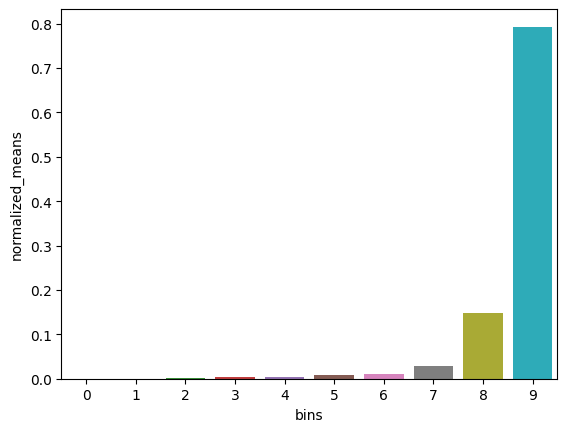

In [233]:
# Difference in revenue vs. popularity bins
pop_df = pd.DataFrame({"means": meta_df.groupby(meta_df['pop_bin'])['revenue'].mean(), "bins":  [i for i in range(10)]})   # Will be useful later
pop_df['normalized_means'] = pop_df['means']/pop_df['means'].sum()
sns.barplot(data=pop_df, x='bins', y='normalized_means')


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]),
 [Text(0, 0, 'Animation'),
  Text(1, 0, 'Adventure'),
  Text(2, 0, 'Romance'),
  Text(3, 0, 'Comedy'),
  Text(4, 0, 'Action'),
  Text(5, 0, 'Family'),
  Text(6, 0, 'History'),
  Text(7, 0, 'Drama'),
  Text(8, 0, 'Crime'),
  Text(9, 0, 'Fantasy'),
  Text(10, 0, 'Science Fiction'),
  Text(11, 0, 'Unknown'),
  Text(12, 0, 'Thriller'),
  Text(13, 0, 'Music'),
  Text(14, 0, 'Horror'),
  Text(15, 0, 'Documentary'),
  Text(16, 0, 'Mystery'),
  Text(17, 0, 'Western'),
  Text(18, 0, 'TV Movie'),
  Text(19, 0, 'War'),
  Text(20, 0, 'Foreign')])

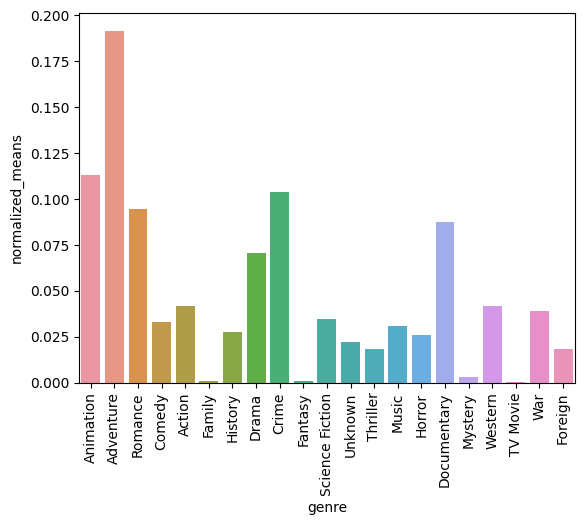

In [235]:
# Difference in budget based on genre
genre_df = pd.DataFrame({'genre': meta_df['main_genre'].unique(), 'means': meta_df.groupby(meta_df['main_genre'])['budget'].mean()})
genre_df['normalized_means'] = genre_df['means']/genre_df['means'].sum()
sns.barplot(data=genre_df, x='genre', y='normalized_means')
plt.xticks(rotation=90)

Finally, I'll set the budget and revenue based on the aforementioned metrics:

In [257]:
for idx, row in meta_df.iterrows():
    if abs(row['budget']) < 100.0:
        median_budget = genre_df[genre_df['genre'] == row['main_genre']]['means']
        meta_df.at[idx, 'budget'] = median_budget.values[0]

    if abs(row['revenue']) < 100.0:
        median_revenue = pop_df[pop_df['bins'] == row['pop_bin']]['means']
        meta_df.at[idx, 'revenue'] = median_revenue.values[0]

In [258]:
meta_df[['revenue', 'budget']].describe()

,revenue,budget
count,4.507400e+04,4.507400e+04
mean,1.543365e+07,8.652409e+06
std,6.519887e+07,1.683259e+07
min,-2.147484e+09,1.000000e+02
25%,1.584208e+05,3.198537e+06
50%,5.501059e+05,4.500000e+06
75%,3.308691e+06,8.524772e+06
max,2.068224e+09,3.800000e+08


Now that these values have been fixed, we can finally add the engineered column.

In [262]:
meta_df['rb_ratio'] = meta_df['revenue'] / meta_df['budget'].astype(np.float32)
meta_df['rb_ratio'].describe()

count    4.507400e+04
mean     5.942046e+01
std      5.133602e+03
min     -9.061112e+00
25%      3.124410e-02
50%      1.680270e-01
75%      1.000000e+00
max      1.018619e+06
Name: rb_ratio, dtype: float64

This column will be useful later on as an extra source of information when calculating similarity.

## Finalizing Item Dataframe

Before I finish off, I'll take one last look at the columns inside `meta_df` to see if there's anything irrelevant that I might want to drop to save on space:

In [345]:
meta_df.to_csv('meta_bu_6.csv',index=False)

In [344]:
meta_df.columns

Index(['adult', 'budget', 'id', 'imdb_id', 'overview', 'popularity',
       'production_companies', 'production_countries', 'revenue', 'runtime',
       'title', 'vote_average', 'Animation', 'Comedy', 'Family', 'Adventure',
       'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror',
       'History', 'Science Fiction', 'Mystery', 'War', 'Foreign', 'Music',
       'Documentary', 'Western', 'TV Movie', 'rb_ratio', 'pop_bin',
       'main_genre'],
      dtype='object')

Now that there are so many extra columns, it might be best to drop less informative columns such as `production_companies`. If needed, I'll re-add this column in future steps, much like how I had re-read the original `movies_metadata.csv` file to obtain all genre data in previous steps.

In [346]:
cols_to_drop = ['production_companies', 'production_countries', 'revenue', 'budget', 'main_genre']
meta_df.drop(cols_to_drop, axis=1, inplace=True)

And the final item dataframe looks like this:

In [348]:
meta_df.head(3)

,adult,id,imdb_id,overview,popularity,runtime,title,vote_average,Animation,Comedy,...,Science Fiction,Mystery,War,Foreign,Music,Documentary,Western,TV Movie,rb_ratio,pop_bin
0,True,862,tt0114709,"Led by Woody, Andy's toys live happily in his ...",21.946943,81.0,Toy Story,7.7,1,1,...,0,0,0,0,0,0,0,0,12.451801,9
1,True,8844,tt0113497,When siblings Judy and Peter discover an encha...,17.015539,104.0,Jumanji,6.9,0,0,...,0,0,0,0,0,0,0,0,4.043035,9
2,True,15602,tt0113228,A family wedding reignites the ancient feud be...,11.712900,101.0,Grumpier Old Men,6.5,0,1,...,0,0,0,0,0,0,0,0,9.609078,9


Here, I'll save `meta_df` in a csv file for later use in our recommendation algorithm.

In [349]:
meta_df.to_csv('items.csv', index=False)

---

# Construct User Dataframe

For this, I'll be using the full `ratings.csv` Dataframe. It's very big though.

I'll construct a new dataframe here, with a column for each movie, and a row for each user. However, I won't be taking every movie into account; only movies that exist in the previously constructed item dataframe. Additionally, I won't be taking all the users into account either; only the first 500 users to avoid making the data too large.

In [4]:
ratings_df = pd.read_csv('./data/ratings.csv')
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


To construct the final users dataframe, I'll first get a list of unique movie ids from the `meta_df` I had created in the previous step. I could also load `items.csv`:

In [5]:
items_df = pd.read_csv('items.csv')
movie_ids = [str(x) for x in items_df['id'].unique().tolist()]    # This will be our column names
col_names = ["user_id"] + movie_ids

In [6]:
user_df = pd.DataFrame(columns=col_names)
user_df.head()

,user_id,862,8844,15602,31357,11862,949,11860,45325,9091,...,84419,390959,289923,222848,30840,439050,111109,67758,227506,461257


Next, I'll iterate over 500 users in `ratings_df`, and fill out `user_df`.

In [14]:
# Takes a while to run

# Get 500 unique users that have given a rating for at least one of the movies
uuids = ratings_df['userId'].unique().tolist()
count = 0
n_users = 500

for i, uuid in enumerate(uuids):
    print(f"User {count}")
    row = np.zeros_like(col_names)
    row[0] = uuid    # Set user id
    # Get list of user reviews so I don't keep doing a search on the entire ratings_df dataframe every time
    ratings_filtered_df = ratings_df[ratings_df['userId'] == uuid]
    for i, movie_id in enumerate(movie_ids):
        movie_rating = ratings_filtered_df[ratings_filtered_df['movieId'] == int(movie_id)]
        if not movie_rating.empty:
            row[i] = movie_rating.rating.values[0]
            made_rating = True
    
    # Only add a specific user rating if the user has made a prediction for at least one of the listed movies (i.e. check to see row is not all 0)
    row[row == ''] = '0'
    row = row.astype(float)
    
    if np.any(row[1:]):
        user_df.loc[len(user_df.index)] = row
        count += 1
    
    if count >= 500:
        break

User 0
User 1
User 2
User 3
User 4
User 5
User 6
User 7
User 8
User 9
User 10
User 11
User 12
User 13
User 14
User 15
User 16
User 17
User 18
User 19
User 20
User 21
User 22
User 23
User 24
User 25
User 26
User 27
User 28
User 29
User 30
User 31
User 32
User 33
User 34
User 35
User 36
User 37
User 38
User 39
User 40
User 41
User 42
User 43
User 44
User 44
User 45
User 46
User 47
User 48
User 49
User 50
User 51
User 52
User 53
User 54
User 55
User 56
User 57
User 58
User 59
User 60
User 61
User 62
User 63
User 64
User 65
User 66
User 67
User 68
User 69
User 70
User 71
User 72
User 73
User 74
User 75
User 76
User 77
User 78
User 79
User 80
User 81
User 82
User 83
User 84
User 85
User 86
User 87
User 88
User 89
User 90
User 91
User 92
User 93
User 94
User 95
User 96
User 97
User 98
User 99
User 100
User 101
User 102
User 103
User 104
User 105
User 106
User 107
User 108
User 109
User 110
User 111
User 112
User 113
User 114
User 115
User 116
User 117
User 118
User 119
User 120
User 121
User

In [13]:
row[row == ''] = '0'
row.astype(float)

array([1, 0, 0, ..., 0, 0, 0])

Now that I've constructed this dataframe, I'll save it as a csv file;

In [393]:
user_df.to_csv('users.csv', index=None)

And that concludes the data preprocessing step.